# Example: Another Look at Sorting - The Quicksort Algorithm
In this example, we compare the average runtime of a recursive [Quicksort](https://en.wikipedia.org/wiki/Quicksort) implementation to our previous [Bubblesort implementation](https://en.wikipedia.org/wiki/Bubble_sort) and [Julia's built-in sort function](https://docs.julialang.org/en/v1/base/sort/#Base.sort) using the [the BenchmarkTools.jl package](https://github.com/JuliaCI/BenchmarkTools.jl). 

We'll complete three main tasks in this notebook:
- **Task 1**: In this task, we'll test our Bubblesort implementation for correctness and benchmark its performance across different array sizes to establish a baseline to compare other algorithms against.
- **Task 2**: In the second task, we'll test our Quicksort implementation for correctness and benchmark its performance to compare against Bubblesort.
- **Task 3**: Finally, we'll benchmark Julia's built-in sort function to see how our custom implementations compare against an optimized library solution.

We are going to see some surprising results! Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

In [25]:
include("Include.jl");

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl), check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types and data used in this material. 

### Implementations
Bubble sort is a simple method of ordering a list. It involves repeatedly passing through the list, comparing adjacent items, and swapping any two neighboring items that are out of order. The algorithm gets its name because smaller elements "bubble" to the top of the list, just like how air bubbles rise to the surface of water.

Let's revisit our previous implementation of the Bubblesort algorithm, which we will use as a baseline for comparison with the Quicksort algorithm.

In [26]:
# Private helper function to swap two elements in an array
function _swap!(array::Array{T,1}, i::Int, j::Int) where T <: Number
    tmp = array[i]
    array[i] = array[j]
    array[j] = tmp
end


"""
    bubblesort(array::Array{T,1}) -> Array{T,1} where T <: Number

Sorts an array using the bubble sort algorithm.

### Arguments
- `array::Array{T,1}`: The array to be sorted, where `T` is a subtype of `Number`.

### Returns
- `Array{T,1}`: A new array containing the sorted elements where the elements are of type `T`.
"""
function bubblesort(array::Array{T,1})::Array{T,1} where T <: Number

    # initialize -
    arr = copy(array) # make a copy of the array
    N = length(arr) # how many elements in the array?

    # main -
    for i ∈ 1:N        
        for j ∈ 1:N-i
            if arr[j] > arr[j+1]
                _swap!(arr, j, j+1)
            end
        end
    end

    # return sorted array -
    return arr
end;

Quicksort takes a different approach to sorting. 

> __How does Quicksort work?__ Quicksort is a recursive sorting algorithm that works by selecting a pivot element and partitioning the remaining elements into two sub-arrays based on their value relative to the pivot. The algorithm then recursively sorts the sub-arrays until they have less than two elements. The choice of pivot is critical for the algorithm's efficiency.

We have a simple implementation of the Quicksort algorithm in Julia below. 

In [27]:
"""
    function quicksort(arr::Array{T,1}) -> Array{T,1} where T <: Number

The `quicksort` function sorts an array of numbers using the quicksort algorithm.

### Arguments
- `arr::Array{T,1}`: An array of numbers to be sorted where `T` is a subtype of `Number`.

### Returns
- `Array{T,1}`: A sorted array of numbers where `T` is a subtype of `Number`.

See: https://en.wikipedia.org/wiki/Quicksort
"""
function quicksort(arr::Array{T,1})::Array{T,1} where T <: Number
    
    # initialize -
    smaller_array = Array{T,1}()
    larger_array = Array{T,1}()

    # Base case: if we only have one element, return the array
    if length(arr) <= 1
        return arr
    else
        
        # Recursive case: we have more than one element in the array 
        # 1. grab the *last* element - we call this the pivot element
        # 2. partition arr into elements that are smaller and larger than the pivot element

        # grab the *last* element of the array - this is the pivot element
        pivot = arr[end]

        # populate the smaller array -
        for x ∈ arr[1:end-1]
            
            # if this value of x is *smaller or equal to* the pivot element, it goes in the smaller array
            # otherwise, x goes in the larger array
            if (x <= pivot)
                push!(smaller_array, x);
            else
                push!(larger_array, x);
            end
        end

        # show the user what is going on ...
        # println("small: $(smaller_array) pivot: $(pivot) large: $(larger_array)")

        # return: this line creates (and returns) an array with the smaller part, the pivot and the larger part
        return [quicksort(smaller_array); pivot; quicksort(larger_array)]
    end
end;

### Constants
Before we get started let's set up some constants. See the comment next to each value for what it is, its permissible values, units, etc.

In [28]:
max_number_of_trials = 12;
number_of_items_per_trial = [2^i for i ∈ 1:max_number_of_trials]; # this is an array comprehension, yet another iteration pattern!

___

## Task 1: Establish a performance baseline: Bubblesort
In this task, we show that our bubblesort implementation works as expected. We also establish a performance baseline for comparison with the Quicksort algorithm.

We'll use [the `Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) to write __unit tests__ for our bubble sort implementation. The [`Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) provides a framework for writing and running tests in Julia, including support for assertions, test cases, and test suites. Let's use [the @test macro](https://docs.julialang.org/en/v1/stdlib/Test/#Test.@test) to check that our bubble sort implementation works correctly.

In [29]:
let

    # initialize -
    N = 1000; # number of elements in the random vector
    arr = rand(N); # random vector length N

    # check: do we get the same result as the built-in sort function?
    @test sort(arr) == bubblesort(arr) # if the test fails, an error is thrown!
end

Test Passed

Ok, so if we get here, all seems to be okay with our `bubblesort(...)` implementation, so let's see how our code performs as we increase the size of the vector that we are sorting.

Now let's measure how our `bubblesort(...)` function performs as we increase the size of the input array. We'll use the [BenchmarkTools.jl package](https://github.com/JuliaCI/BenchmarkTools.jl) to get accurate timing measurements.

The code below uses a [`let ... end` block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) to create a local scope and performs the following steps:
1. **Initialize a DataFrame** to store our results with columns for array size (`n`), mean runtime (`μ`), and standard deviation (`σ`) using the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl)
2. **Loop through different array sizes** from our `number_of_items_per_trial` array (powers of 2 from $2^{1}$ to $2^{12}$)
3. **For each array size:**
   - Create a benchmark using `@benchmarkable` that will test our `bubblesort` function
   - Use `setup=` to generate fresh random data for each trial (avoiding measuring data generation time)
   - Run the benchmark multiple times and collect timing statistics
   - Store the results (array size, mean time, standard deviation) as a row in our DataFrame

The result will be stored in the `bubble_sort_data::DataFrame` variable containing performance data that we can analyze and visualize.

In [30]:
bubble_sort_data = let
    bubble_sort_data = DataFrame();
    for i ∈ eachindex(number_of_items_per_trial)
        size_of_rand_vec_to_sort = number_of_items_per_trial[i];
    
        # run the test with different size vectors -
        test_run = @benchmarkable bubblesort(data) setup=(data=rand(0:number_of_items_per_trial[end], $(size_of_rand_vec_to_sort)));
        tune!(test_run)
        results = run(test_run)
    
        # store the results -
        row = (
            n = size_of_rand_vec_to_sort,
            μ = mean(results.times),
            σ = std(results.times)
        );
        push!(bubble_sort_data, row)
    end
    bubble_sort_data
end

Row,n,μ,σ
,Int64,Float64,Float64
1,2,75.2181,304.629
2,4,87.4084,298.488
3,8,110.846,322.447
4,16,199.562,419.286
5,32,594.073,1390.27
6,64,2564.58,234.893
7,128,11859.8,970.416
8,256,47900.1,3117.05
9,512,1.60231e5,6304.15


## Task 2: Quicksort
In this task, we verify that our Quicksort implementation works as expected. We also establish the performance of this method in comparison with the Bubblesort algorithm.

As before,  we'll use [the `Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) to write a __unit test__ for our `quicksort(...)` implementation. The [`Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) provides a framework for writing and running tests in Julia, including support for assertions, test cases, and test suites. Let's use [the @test macro](https://docs.julialang.org/en/v1/stdlib/Test/#Test.@test) to check that our `quicksort(...)` implementation works correctly.

In [31]:
let

    # initialize -
    N = 1000; # number of elements in the random vector
    arr = rand(N); # random vector length N

    # check: do we get the same result as the built-in sort function?
    @test sort(arr) == quicksort(arr) # if the test fails, an error is thrown!
end

Test Passed

Ok, so if we get here, all seems to be okay with our `quicksort(...)` implementation, so let's see how our code performs as we increase the vector size to be sorted. 

Let's use the same benchmarking pattern as we did for the Bubblesort algorithm. The benchmarking results for the Quicksort algorithm will be stored in the `quick_sort_data::DataFrame` variable containing performance data that we can analyze and visualize.

In [32]:
quick_sort_data = let
    
    quick_sort_data = DataFrame();
    for i ∈ eachindex(number_of_items_per_trial)
        size_of_rand_vec_to_sort = number_of_items_per_trial[i];
    
        # run the test with different size vectors -
        test_run = @benchmarkable quicksort(data) setup=(data=rand(0:number_of_items_per_trial[end], $(size_of_rand_vec_to_sort)));
        tune!(test_run)
        results = run(test_run)
    
        # store the results -
        row = (
            n = size_of_rand_vec_to_sort,
            μ = mean(results.times),
            σ = std(results.times)
        );
        push!(quick_sort_data, row)
    end
    quick_sort_data
end

Row,n,μ,σ
,Int64,Float64,Float64
1,2,413.268,1441.01
2,4,924.186,2638.14
3,8,1957.97,17093.4
4,16,4170.64,29362.4
5,32,8913.3,61689.9
6,64,19431.5,1.86268e5
7,128,44028.4,3.00561e5
8,256,81556.9,393720.0
9,512,1.6509e5,4.4743e5


## Task 3: What is the scaling of the Built-in sort function?
Julia provides [sophisticated multi-method sorting capability](https://docs.julialang.org/en/v1/base/sort/#Sorting-Functions). How do our implementations perform against what Julia can offer? 

> __Buy versus build:__ This is yet another example of the __buy versus build__ conundrum. Should we build our own implementation, or __buy__ someone elses? You should (almost) always __buy__, and benefit from the hard (optimized) work of others.  But let's see if that is true in this case.

We'll use the same benchmarking approach as we did for the Bubblesort and Quicksort algorithms. The results will be stored in the `julia_sort_data::DataFrame` variable containing performance data that we can analyze and visualize.

In [33]:
julia_sort_data = let
    julia_sort_data = DataFrame();
    for i ∈ eachindex(number_of_items_per_trial)
        size_of_rand_vec_to_sort = number_of_items_per_trial[i];
    
        # run the test with different size vectors -
        test_run = @benchmarkable sort(data) setup=(data=rand(0:number_of_items_per_trial[end], $(size_of_rand_vec_to_sort)));
        tune!(test_run)
        results = run(test_run)
    
        # store the results -
        row = (
            n = size_of_rand_vec_to_sort,
            μ = mean(results.times),
            σ = std(results.times)
        );
        push!(julia_sort_data, row)
    end
    julia_sort_data
end

Row,n,μ,σ
,Int64,Float64,Float64
1,2,80.7886,333.722
2,4,84.2416,324.247
3,8,95.7266,346.067
4,16,127.984,393.524
5,32,224.015,423.064
6,64,551.091,1627.55
7,128,819.755,2093.61
8,256,1600.78,18220.9
9,512,2807.99,23531.6


## Visualize
`Unhide` the code below to see how we plotted the average runtime of each sorting method as a function of the length of the vector $n$.

> __Summary__: For very short sequences, our `bubblesort(...)` implementation is the winner! However, once the sequences become large, [Julia `sort(...)` implementations are the clear winners](https://docs.julialang.org/en/v1/base/sort/#Sorting-Functions). Something is interesting here: our `quicksort(...)` implementation seems to have similar scaling behavior to [the built-in `sort(...)` method](https://docs.julialang.org/en/v1/base/sort/#Sorting-Functions).

These results show the power of constants! When we doing scaling analysis we ignore constants, but they are important in practice. For example, Quicksort and Julia's built-in sort function have similar scaling behavior, but the constants are different (the built-in sort implementation appears to have a smaller constant factor, meaning it is faster in practice).

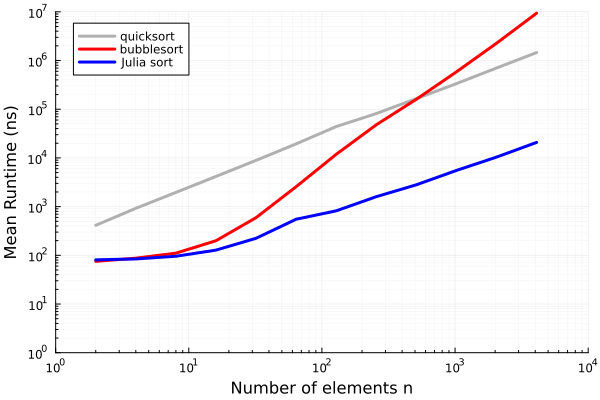

In [34]:
let
    plot(quick_sort_data[:,:n], quick_sort_data[:,:μ], label="quicksort", 
        yscale=:log10, xscale=:log10, lw=3, c=:gray69, minorgrid=true, legend=:topleft)
    plot!(bubble_sort_data[:,:n], bubble_sort_data[:,:μ], label="bubblesort", 
        yscale=:log10, xscale=:log10, lw=3, c=:red)
    plot!(julia_sort_data[:,:n], julia_sort_data[:,:μ], label="Julia sort", 
        yscale=:log10, xscale=:log10, lw=3, c=:blue)
    xlims!(1e+0, 1e+4)
    ylims!(1e+0, 1e+7)
    xlabel!("Number of elements n", fontsize=18)
    ylabel!("Mean Runtime (ns)", fontsize=18)
end

## Summary
So what did we learn from comparing these three sorting approaches? Surprisingly, our simple bubblesort actually wins for very small datasets, but it quickly becomes the slowest as the data grows due to its O(n²) complexity.

Our quicksort implementation shows much better scaling behavior, performing similarly to Julia's built-in sort in terms of growth rate. However, Julia's optimized sort function consistently outperforms our implementation with better constants and lower overhead.

The key takeaway? This is a perfect example of the "buy vs build" principle in programming. While implementing algorithms yourself is great for learning, production code should almost always use well-tested library functions that have been optimized by experts!